# Support Vector Machines

Машины опорных векторов (SVM) - это особенно мощный и гибкий класс контролируемых алгоритмов как для классификации, так и для регрессии.
В этом разделе мы рассмотрим логику, лежащую в основе SVM и использование алгоритма в задачах классификации.

Начнем со стандартного импорта:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

##  Support Vector Machines

В рамках нашего обсуждения байесовской классификации мы изучили простую модель, описывающую распределение каждого базового класса, и использовали эти генеративные модели для вероятностного определения метки.
Это был пример *генеративной классификации*; здесь мы рассмотрим вместо этого *дискриминационную классификацию*: вместо моделирования каждого класса мы просто находим линию или кривую (в двух измерениях) или множество линий (в нескольких измерениях), которые отделяют классы друг от друга.

В качестве примера рассмотрим простой случай задачи классификации, в которой два класса точек хорошо разделены:

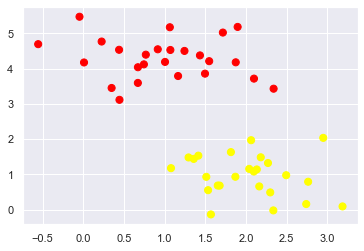

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Линейный дискриминантный классификатор попытается провести прямую линию, разделяющую два набора данных, и тем самым создать модель для классификации.
Для двумерных данных, подобных показанным здесь, это задача, которую мы можем выполнить вручную.
Но сразу же мы видим проблему: существует несколько возможных разделительных линий, которые могут идеально различать два класса!

Мы можем нарисовать их следующим образом:

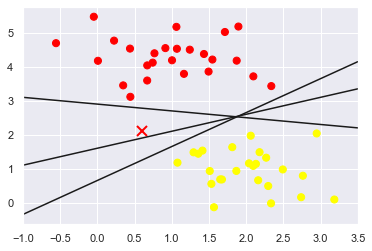

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Это три *очень* разных разделителя, которые, тем не менее, отлично различают эти образцы.
В зависимости от того, что вы выберете, в новой точке данных (например, той, которая отмечена «X» на этом графике) будет присвоена другая метка!
Очевидно, нашей простой логики «провести черту между классами» недостаточно, и нам нужно подумать немного глубже.

## Support Vector Machines: максимизация зазора

Support vector machines предлагают один из способов улучшения.
Логика такова: вместо того, чтобы просто рисовать линию нулевой ширины между классами, мы можем нарисовать вокруг каждой линии *поле* некоторой ширины, вплоть до ближайшей точки.
Вот пример того, как это может выглядеть:

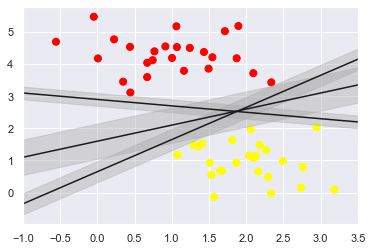

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

В SVM линия, которая максимизирует этот запас, - это та линия, которую мы выберем в качестве оптимальной модели.
Машины опорных векторов являются примером оценки *максимального зазора*.

### Применение support vector machine

Давайте посмотрим на результат фактического соответствия этим данным: мы будем использовать классификатор векторов поддержки Scikit-Learn для обучения модели SVM на этих данных.
На данный момент мы будем использовать линейное ядро и установим параметр C на очень большое значение (мы обсудим их значение более подробно дальше).

In [6]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Чтобы лучше представить себе, что здесь происходит, давайте создадим быструю удобную функцию, которая построит для нас границы решений SVM:

In [7]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

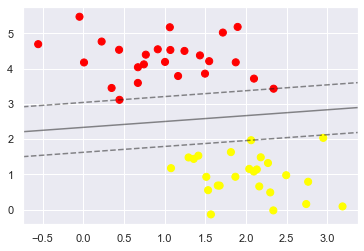

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Это разделительная линия, которая увеличивает расстояние между двумя наборами точек.
Обратите внимание, что некоторые тренировочные точки просто касаются края.
Эти точки являются ключевыми элементами этой подгонки, известны как *опорные векторы* и дают название алгоритму.
В Scikit-Learn идентичность этих точек хранится в атрибуте support_vectors_ классификатора:

In [9]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Ключом к успеху этого классификатора является то, что для подгонки имеет значение только положение опорных векторов; любые точки дальше от края, которые находятся на правильной стороне, не влияют на результат!
Технически это связано с тем, что эти точки не влияют на функцию потерь, используемую для соответствия модели, поэтому их положение и количество не имеют значения, пока они не пересекают границу.

Мы можем увидеть это, например, если мы построим модель, изученную по первым 60 точкам и первым 120 точкам этого набора данных:

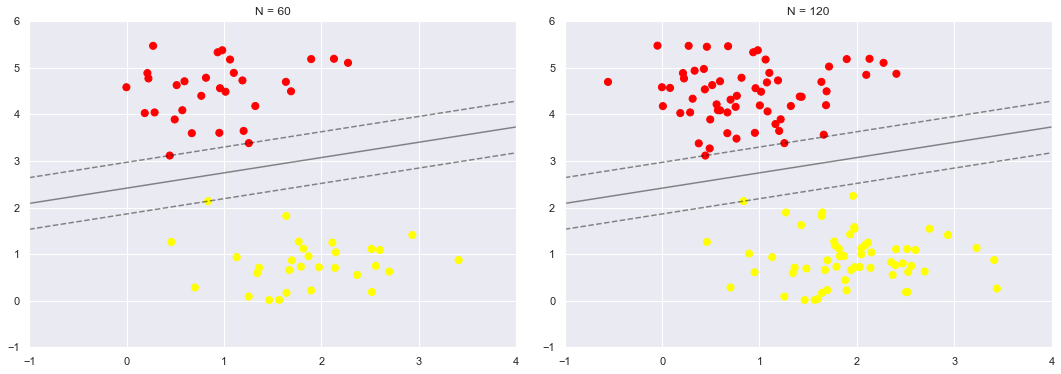

In [10]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

На левом графике мы видим модель и опорные векторы для 60 обучающих точек.
На правом графике мы удвоили количество обучающих точек, но модель не изменилась: три опорных вектора из левой панели по-прежнему являются опорными векторами из правой панели.
Эта нечувствительность к точному поведению удаленных точек - одна из сильных сторон модели SVM.

### За пределами линейных границ: ядро SVM

Когда SVM становится чрезвычайно мощным, так это когда он сочетается с *ядрами*.
Мы спроецировали наши данные в многомерное пространство, определяемое полиномами и базисными функциями Гаусса, и, таким образом, смогли приспособиться к нелинейным отношениям с линейным классификатором.

В моделях SVM мы можем использовать версию той же идеи.
Чтобы объяснить потребность в ядрах, давайте посмотрим на некоторые данные, которые нельзя разделить линейно:

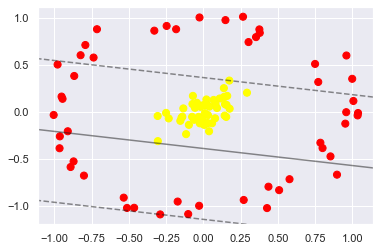

In [15]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Ясно, что никакая линейная функция *никогда* не сможет разделить эти данные.
Но мы можем извлечь урок из регрессий базисных функций и подумать о том, как мы могли бы спроецировать данные в более высокое измерение, чтобы линейный разделитель мог быть достаточным.
Например, одна простая проекция, которую мы могли бы использовать, - это вычислить *радиально-базисную функцию* с центром в среднем сгустке:

In [16]:
r = np.exp(-(X ** 2).sum(1))

Мы можем визуализировать это дополнительное измерение данных с помощью трехмерного графика - если вы запускаете этот ноутбук вживую, вы сможете использовать ползунки для поворота графика:

In [25]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')


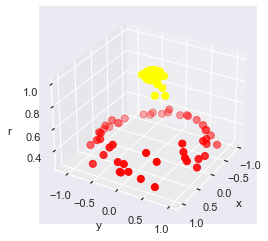

In [27]:
plot_3D()

Мы можем увидеть, что с этим дополнительным измерением данные становятся тривиально линейно разделяемыми, если нарисовать разделяющую плоскость, скажем, при *r* = 0,7.

Здесь нам пришлось выбрать и тщательно настроить нашу проекцию: если бы мы не центрировали нашу радиально-базисную функцию в правильном месте, мы не увидели бы таких чистых, линейно разделимых результатов.
В общем, необходимость сделать такой выбор является проблемой: мы хотели бы каким-то образом автоматически находить лучшие базовые функции для использования.

Одна из стратегий для этого - вычислить базисную функцию с центром в *каждой* точке набора данных и позволить алгоритму SVM просеивать результаты.
Этот тип преобразования базисной функции известен как *преобразование ядра*, поскольку он основан на соотношении подобия (или ядре) между каждой парой точек.

Потенциальная проблема этой стратегии - проецирования $N$ точек в $N$ измерений - состоит в том, что она может стать очень ресурсоемкой по мере роста $N$.
Однако из-за небольшой процедуры, известной как *трюк с ядром*, подбор данных, преобразованных ядром, может выполняться неявно, то есть без построение полного $N$ - мерного представления проекции ядра!
Этот трюк с ядром встроен в SVM и является одной из причин, по которой этот метод настолько эффективен.

В Scikit-Learn мы можем применить SVM с ядром, просто изменив наше линейное ядро на ядро RBF (радиальная базисная функция), используя гиперпараметр модели kernel

In [28]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

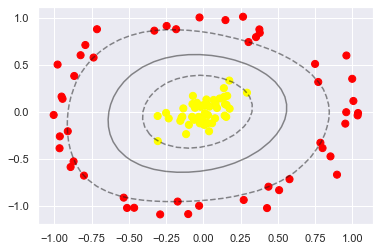

In [29]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Используя эту ядровую опорную векторную машину, мы находим подходящую нелинейную границу решения.
Эта стратегия преобразования ядра часто используется в машинном обучении для превращения быстрых линейных методов в быстрые нелинейные методы, особенно для моделей, в которых можно использовать трюк с ядром.

### Настройка SVM: сглаживание зазоров

Наше обсуждение до сих пор было сосредоточено на очень чистых наборах данных, в которых существует идеальная граница принятия решения.
Но что, если ваши данные частично перекрываются?
Например, у вас могут быть такие данные:

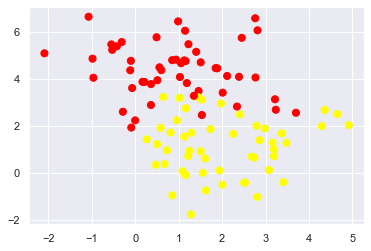

In [30]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Чтобы справиться с этим случаем, в реализации SVM есть некоторый фактор, который «смягчает» зазор: то есть позволяет некоторым точкам проникать в границы, если это позволяет лучше соответствовать.
Жесткость запаса регулируется параметром настройки, чаще всего известным как $C$.
Для очень больших $C$ зазор жесткий.
Для меньших $C$ зазор более мягкий и может увеличиваться до некоторых точек.

График, показанный ниже, дает визуальную картину того, как изменение параметра $C$ влияет на окончательную подгонку за счет смягчения поля:

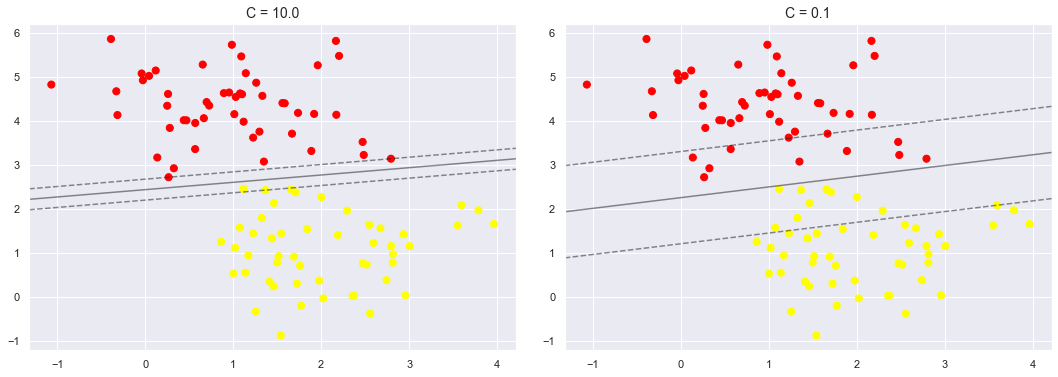

In [31]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Оптимальное значение параметра $C$ будет зависеть от вашего набора данных и должно быть настроено с помощью перекрестной проверки или GridSearch.

## Пример: Face Recognition

В качестве примера работы машин опорных векторов давайте взглянем на проблему распознавания лиц.
Мы будем использовать набор данных Labeled Faces in the Wild, который состоит из нескольких тысяч сопоставленных фотографий различных общественных деятелей.
Набор данных встроен в Scikit-Learn:

In [34]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


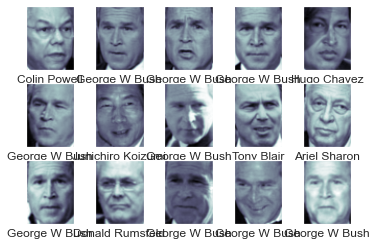

In [35]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Каждое изображение содержит [62 × 47] или почти 3000 пикселей. Мы могли бы продолжить, просто используя значение каждого пикселя как признак, но часто более эффективно использовать какой-либо препроцессор для извлечения более значимых признаков; здесь мы будем использовать анализ главных компонент (см. Подробно: PCA будет в обучении без учителя), чтобы извлечь 150 фундаментальных компонент, которые будут использоваться в нашем машинном классификаторе опорных векторов. Мы можем сделать это наиболее просто, упаковав препроцессор и классификатор в один пайплайн:

In [38]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Для тестирования наших выходных данных классификатора мы разделим данные на набор для обучения и тестирования:

In [40]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Наконец, мы можем использовать перекрестную проверку поиска по сетке для изучения комбинаций параметров. Здесь мы настроим С(который контролирует жесткость зазора) и гамму (которая контролирует размер ядра радиальной базисной функции) и определим лучшую модель:

In [42]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 54.7 s, sys: 5.5 s, total: 1min
Wall time: 24.4 s
{'svc__C': 10, 'svc__gamma': 0.001}


Оптимальные значения попадают в середину нашей сетки; если они попадут по краям, то мы  расширим сетку, чтобы убедиться, что мы нашли истинный оптимум.

Теперь с помощью этой модели с перекрестной проверкой мы можем предсказать метки для тестовых данных, которые модель еще не видела:

In [43]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Давайте посмотрим на несколько тестовых изображений вместе с их предсказанными значениями:

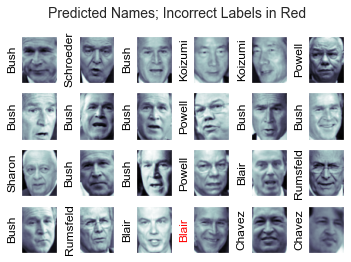

In [44]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Из этой небольшой выборки наша оптимальная оценка ошибочно пометила только одно лицо (Буш в нижнем ряду был неправильно помечен как Блер).
Мы можем получить лучшее представление о производительности нашего оценщика, используя отчет о классификации, в котором статистика восстановления перечисляется метка за меткой:

In [45]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



Мы также можем отобразить конфьюжен матрицу  между этими классами

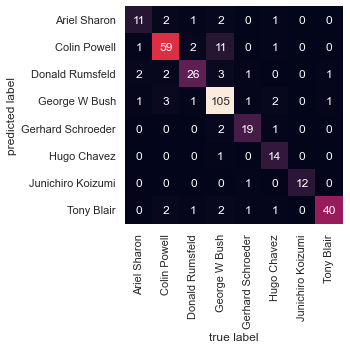

In [46]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Это помогает нам понять, какие метки могут быть сбиты с толку оценщиком.

Для реальной задачи распознавания лиц, в которой фотографии не предварительно обрезаны в красивые сетки, единственное различие в схеме классификации лиц - это выбор функций: вам нужно будет использовать более сложный алгоритм для поиска лиц, и извлечения элементов, не зависящих от пикселизации. Для такого рода приложений одним из хороших вариантов является использование OpenCV, который, среди прочего, включает предварительно обученные реализации современных инструментов извлечения функций для изображений в целом и лиц в частности.

## Support Vector Machine заключение

Мы видели здесь краткое логическое введение в принципы, лежащие в основе машин опорных векторов.
Эти методы являются мощным методом классификации по ряду причин:

- Их зависимость от относительно небольшого числа опорных векторов означает, что они очень компактные модели и занимают очень мало памяти.
- После обучения модели фаза прогнозирования выполняется очень быстро.
- Поскольку на них влияют только точки около границы, они хорошо работают с данными большой размерности - даже с данными с большим количеством измерений, что является сложным для других алгоритмов.
- Их интеграция с методами ядра делает их очень универсальными, способными адаптироваться ко многим типам данных.

Однако у SVM есть и ряд недостатков:

- Масштабирование с количеством выборок $N$ равно $\mathcal {O}[N^3]$ в худшем случае или $\mathcal {O}[N^2]$ для эффективных реализаций. Для большого количества обучающих выборок эти вычислительные затраты могут быть непомерно высокими.
- Результаты сильно зависят от подходящего выбора параметра смягчения $C$. Это должно быть тщательно выбрано с помощью перекрестной проверки, которая может быть дорогостоящей, поскольку наборы данных растут в размере.
- Результаты не имеют прямой вероятностной интерпретации. Это можно оценить с помощью внутренней перекрестной проверки (см. Параметр `` вероятность`` в `` SVC ``), но эта дополнительная оценка стоит дорого.

Помня об этих особенностях, я обычно обращаюсь к SVM только тогда, когда другие более простые, быстрые и менее требовательные к настройке методы оказываются недостаточными для моих нужд.
Тем не менее, если у вас есть процессоры для обучения и перекрестной проверки SVM на ваших данных, этот метод может привести к отличным результатам.
